In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from src.viz import plot_bipartite_graph
from src.utils import generate_bipartite_erdos_graph
from src.opt import BudgetedAllocationSolver

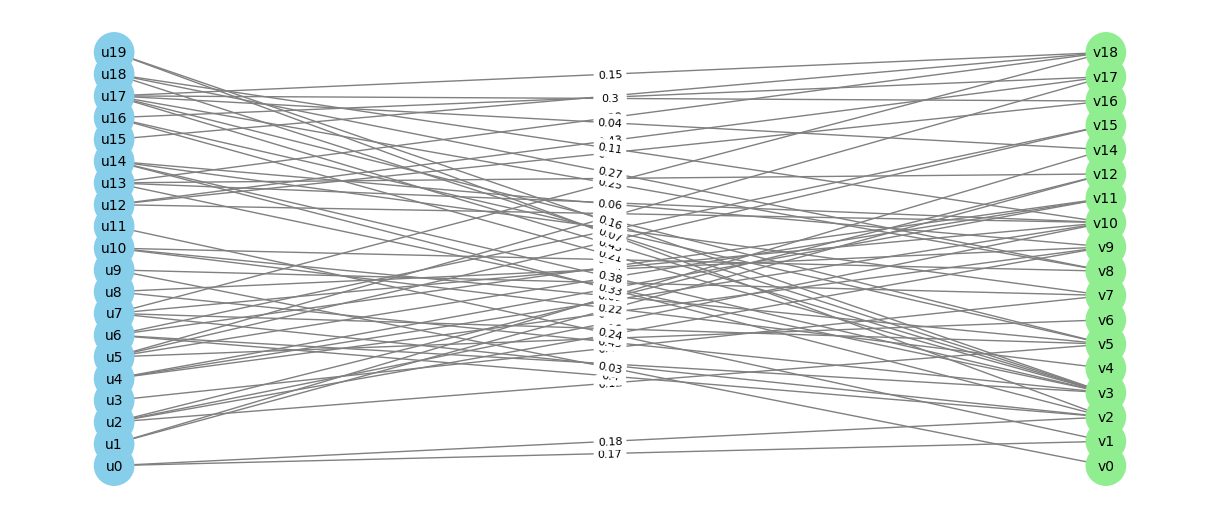

In [3]:
n_U, n_V = 20, 20

B, edges = generate_bipartite_erdos_graph(n_U, n_V, p_erd=np.log(n_U)/n_U, p_max=0.5)

U = [f"u{i}" for i in range(n_U)]
V = [f"v{j}" for j in range(n_V)]

plot_bipartite_graph(B, U, V, save_fig='./figs/graph_example.png')

In [12]:
import random
import networkx as nx

class OnlineMatchingEvaluator:
    def __init__(self, algorithm, graph, edges):
        """
        :param model: Un modèle qui prend en entrée un noeud v et ses arêtes et renvoie un noeud u.
        :param graph: Un graphe biparti NetworkX avec des poids sur les arêtes.
        """
        self.algorithm = algorithm
        self.graph = graph
        self.score = 0
        self.matched = set()
        self.opt_calculator = BudgetedAllocationSolver(graph, edges)
        _, self.opt = self.opt_calculator.run()

        self.successful_assignments = {}

    def run(self):
        """ Exécute l'évaluation en soumettant chaque v séquentiellement au modèle. """

        V = [node for node, data in self.graph.nodes(data=True) if data['bipartite'] == 1]
        
        for v in V:
            edges = [(v, u, self.graph[v][u]['weight']) for u in self.graph.neighbors(v)]
            
            if not edges:
                continue


            chosen_u = self.algorithm(v, edges, self.successful_assignments)

            if chosen_u and (v, chosen_u, self.graph[v][chosen_u]['weight']) in edges:
                success = random.uniform(0, 1) < self.graph[v][chosen_u]['weight']

                if success and (chosen_u not in self.successful_assignments or not self.successful_assignments[chosen_u]):
                    self.score += 1
                    self.matched.add((v, chosen_u))
                    self.successful_assignments[chosen_u] = True 

        return self.score

In [11]:
def simple_model(v, edges, set_u=None):
    return max(edges, key=lambda e: e[2])[1] if edges else None


evaluator = OnlineMatchingEvaluator(simple_model, B, edges)
evaluator.run()

4

In [10]:
# OPT pour ce modèle:
evaluator.opt

5.846250000000332

In [18]:
# Le code marche pas encore faut que je regarde pour le corriger

class NonAdaptive:
    def __init__(self, edges):
        self.u_edges = [edge[0] for edge in edges]
        self.w = {}
        for u in self.u_edges:
            self.w[u] = 0

    def find_max_u(self, p):

        return max((u for v0, u, p_value in p if u in self.w), 
                key=lambda u: (1 - self.w[u]) * next(p_value for v0, u2, p_value in p if u == u2), 
                default=None)

    def __call__(self, v, edges, set_u=None):

        selected_u = self.find_max_u(edges)

        self.w[selected_u] = self.w[selected_u] + (1-self.w[selected_u])*get_weight_for_u(edges, selected_u)
        return selected_u


def get_weight_for_u(p, u):
    for v0, current_u, weight in p:
        if current_u == u:
            return weight
    return None


In [26]:
algo = NonAdaptive(edges)

evaluator = OnlineMatchingEvaluator(algo, B, edges)
evaluator.run()

6